In [1]:
from pyburn import read_band_image, nbr, dnbr, array2raster, clip_raster, reclassify, reproject_shp_gdal

In [2]:
# Paths to Sentinel-2 images (pre-fire and post-fire)
path_prefire_nir = r"C:\Users\Dell\Downloads\Pre fire satellite images sentinel 2\S2B_MSIL2A_20210728T094029_N0500_R036_T33SXD_20230220T230541.SAFE\GRANULE\L2A_T33SXD_A022942_20210728T094408\IMG_DATA\R20m\T33SXD_20210728T094029_B8A_20m.jp2"
path_prefire_swir = r"C:\Users\Dell\Downloads\Pre fire satellite images sentinel 2\S2B_MSIL2A_20210728T094029_N0500_R036_T33SXD_20230220T230541.SAFE\GRANULE\L2A_T33SXD_A022942_20210728T094408\IMG_DATA\R20m\T33SXD_20210728T094029_B12_20m.jp2"
path_postfire_nir = r"C:\Users\Dell\Downloads\Post fire satellite images sentinel 2\S2B_MSIL2A_20210817T094029_N0500_R036_T33SXD_20230216T200808.SAFE\GRANULE\L2A_T33SXD_A023228_20210817T094030\IMG_DATA\R20m\T33SXD_20210817T094029_B8A_20m.jp2"
path_postfire_swir = r"C:\Users\Dell\Downloads\Post fire satellite images sentinel 2\S2B_MSIL2A_20210817T094029_N0500_R036_T33SXD_20230216T200808.SAFE\GRANULE\L2A_T33SXD_A023228_20210817T094030\IMG_DATA\R20m\T33SXD_20210817T094029_B12_20m.jp2"
# Path to shapefile
infile_shp = r"C:\Users\Dell\Downloads\crotene\crotene.shp"

In [3]:
# Path for the reprojected shapefile
outfile_shp = r"C:\Users\Dell\Downloads\reprojected_shapefile.shp"  # save the reprojected shapefile in your preferred file path 

# Output filenames
filename = r"C:\Users\Dell\Downloads\output_dnbr.tiff"   # save the dnbr in your preferred file path 
filename2 = r"C:\Users\Dell\Downloads\output_clipped_dnbr.tiff"   # save the clipped_dnbr in your preferred file path
fname = r"C:\Users\Dell\Downloads\output_burn_severity_map.png"    # save the burn_severity_map in your preferred file path

In [4]:
## Read pre-fire NIR and SWIR images
pre_fire_nir, crs, geoTransform, targetprj = read_band_image(path_prefire_nir)
pre_fire_swir, crs, geoTransform, targetprj = read_band_image(path_prefire_swir)

In [5]:
# Read post-fire NIR and SWIR images
post_fire_nir, crs, geoTransform, targetprj = read_band_image(path_postfire_nir)
post_fire_swir, crs, geoTransform, targetprj = read_band_image(path_postfire_swir)

In [6]:
# Calculate pre-fire NBR
pre_fire_nbr = nbr(pre_fire_nir.astype(int), pre_fire_swir.astype(int))

In [7]:
# Calculate post-fire NBR
post_fire_nbr = nbr(post_fire_nir.astype(int), post_fire_swir.astype(int))

In [8]:
# Calculate dNBR (pre-fire NBR - post-fire NBR)
DNBR = dnbr(pre_fire_nbr, post_fire_nbr)

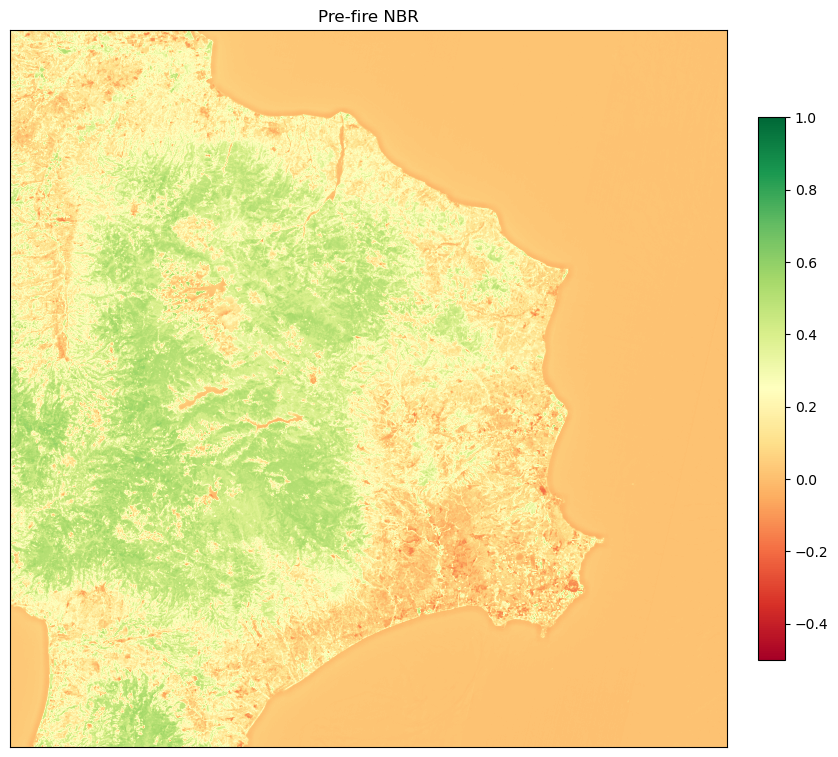

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
# VISUALIZE THE IMAGES
# ---------------------------------------------------
# 1. Visualize Pre-fire NBR
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(pre_fire_nbr, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
plt.title('Pre-fire NBR')
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04)
plt.show()
plt.savefig('pre_fire_nbr.png', bbox_inches="tight")

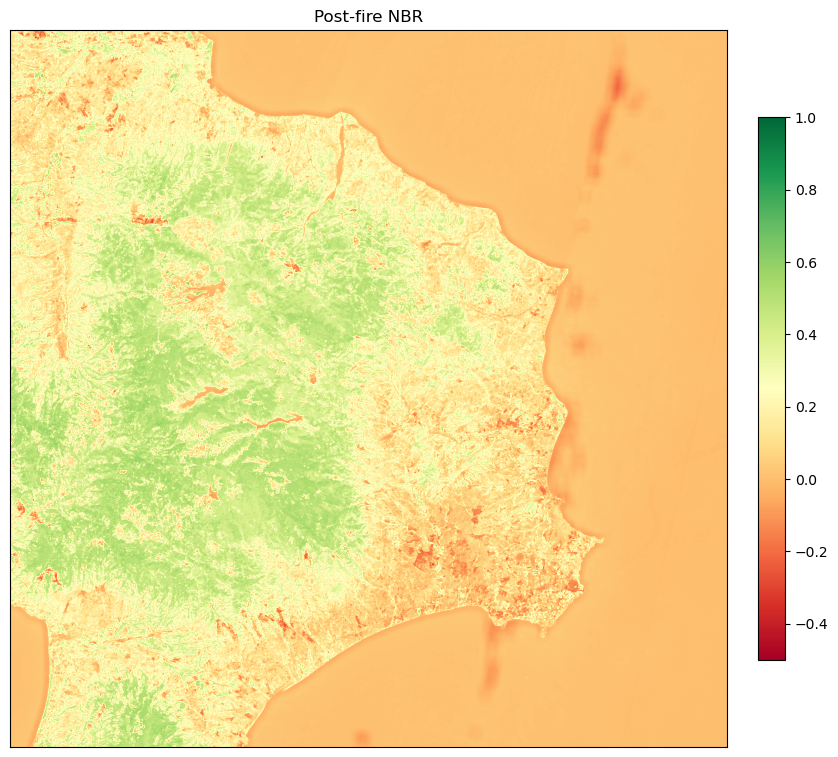

<Figure size 640x480 with 0 Axes>

In [10]:
# 2. Visualize Post-fire NBR
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(post_fire_nbr, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
plt.title('Post-fire NBR')
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04)
plt.show()
plt.savefig('post_fire_nbr.png', bbox_inches="tight")

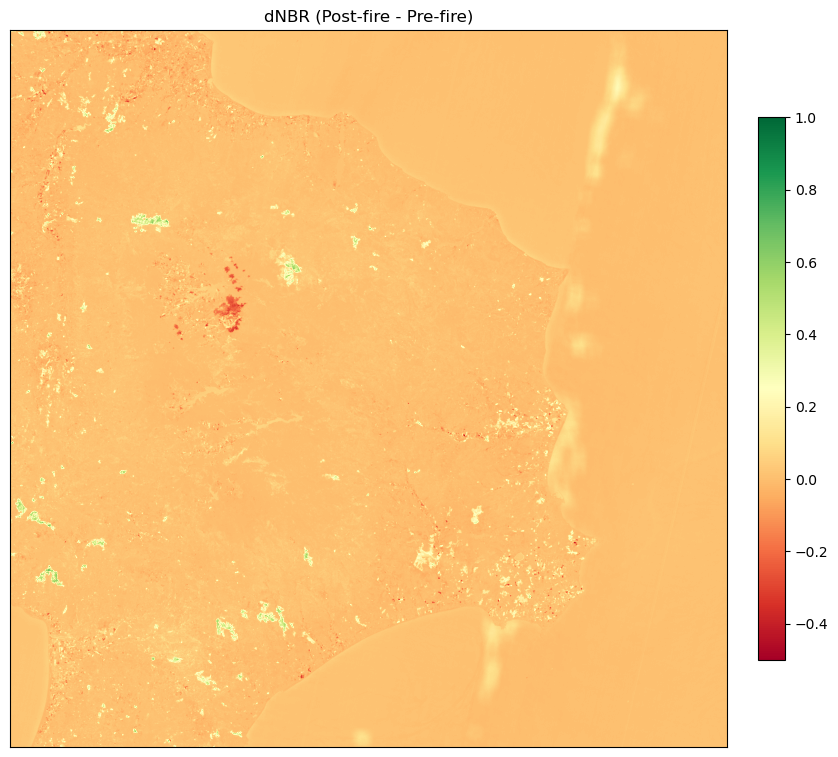

<Figure size 640x480 with 0 Axes>

In [11]:
# 3. Visualize dNBR (Post-fire NBR - Pre-fire NBR)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
cax = ax.imshow(DNBR, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
plt.title('dNBR (Post-fire - Pre-fire)')
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04)
plt.show()
plt.savefig('dnbr.png', bbox_inches="tight")

In [12]:
# Reproject the shapefile to match the Sentinel-2 image projection
reproject_shp_gdal(infile_shp, outfile_shp, targetprj)

In [13]:
# Read the reprojected shapefile
import geopandas as gpd
fire_boundary = gpd.read_file(outfile_shp)

In [14]:
# Save dNBR to a GeoTIFF
dnbr_tif, dnbr_tifBand = array2raster(DNBR, geoTransform, crs, filename)

In [15]:
# Clip the dNBR raster using the reprojected shapefile
(clipped_dnbr, clipped_dnbr_meta, cr_extent, gt) = clip_raster(filename, fire_boundary)

In [16]:
# Save the clipped dNBR to a new GeoTIFF
clipped_ds, clipped_ds_rasterband = array2raster(clipped_dnbr[0], gt, crs, filename2)

In [17]:
# Plot the burn severity map (which you already have)
# Custom burn severity colors
from matplotlib.colors import ListedColormap

In [18]:
# Define your custom colormap using the specified colors: green, yellow, orange, red, purple
cmap = ListedColormap(['green', 'yellow', 'orange', 'red', 'purple'])

In [19]:
# Normalize to the severity levels 1 to 5 (based on reclassification)
from matplotlib.colors import Normalize
norm = Normalize(vmin=1, vmax=5)  # Values corresponding to reclassification (1 to 5)

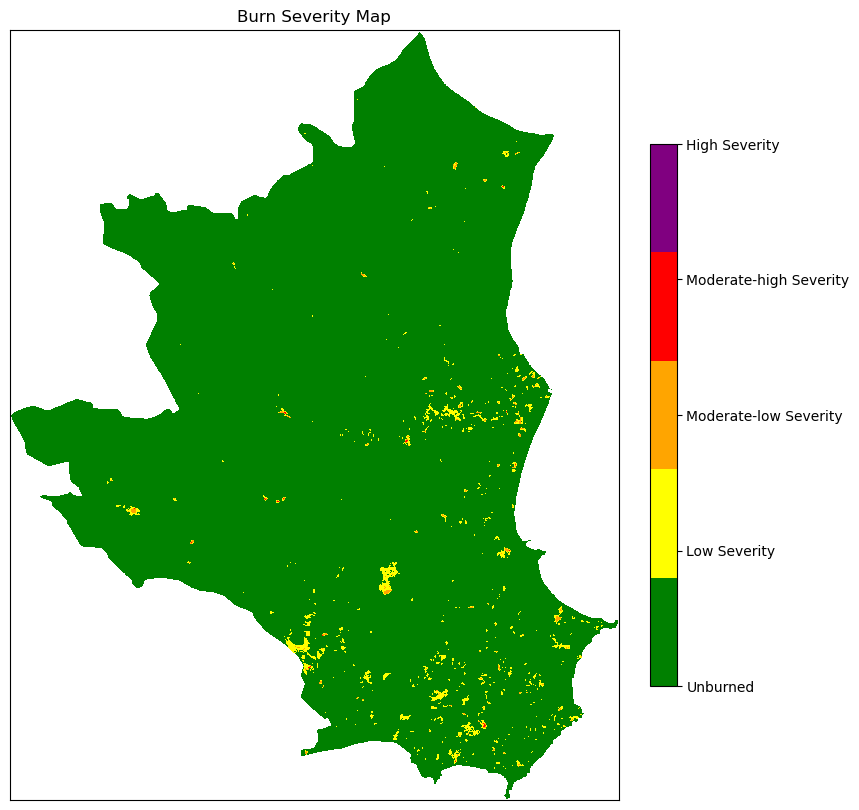

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot the burn severity map based on reclassified values (not raw dNBR)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

# Use the reclassified array for plotting
reclassified_array = reclassify(clipped_ds_rasterband.ReadAsArray())

# Display the reclassified burn severity map
cax = ax.imshow(reclassified_array, cmap=cmap, norm=norm)

# Title and colorbar
plt.title('Burn Severity Map')
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity'])

# Show and save the figure
plt.show()
plt.savefig(fname, bbox_inches="tight")

In [ ]:
# Calculate burnt area based on reclassified dNBR
reclass = reclassify(clipped_ds_rasterband.ReadAsArray())
severity_labels = ['Unburned hectares', 'Low severity hectares', 'Moderate-low severity hectares', 'Moderate-high severity hectares', 'High severity']
for i in range(1, 6):
    x = reclass[reclass == i]
    area = x.size * 0.04  # Pixel size (20m x 20m)
    print(f"{severity_labels[i-1]}: {area:.2f} hectares")